In [2]:
import numpy as np
import tensorflow as tf
from adult_modified import preprocess_adult_data
from sklearn import linear_model
import classifier as cl
import utils
import time
import multiprocessing as mp
import dill


seed = 1
dataset_orig_train, dataset_orig_test = preprocess_adult_data(seed = seed)

x_unprotected_train, x_protected_train = dataset_orig_train.features[:, :39], dataset_orig_train.features[:, 39:]
x_unprotected_test, x_protected_test = dataset_orig_test.features[:, :39], dataset_orig_test.features[:, 39:]
y_train, y_test = dataset_orig_train.labels.reshape((-1,)), dataset_orig_test.labels.reshape((-1,))





## Running linear regression to get sensetive directions 

protected_regression = linear_model.LinearRegression(fit_intercept = False)
protected_regression.fit(x_unprotected_train, x_protected_train)
sensetive_directions = protected_regression.coef_

def projection_matrix(sensetive_directions):
    n, d = sensetive_directions.shape
    mx = np.identity(d)
    for vector in sensetive_directions:
        vector = vector/np.linalg.norm(vector, ord=2)
        vector = vector.reshape((-1,1))
        mx = mx - 0.99* vector @ vector.T
    return mx




unprotected_directions = projection_matrix(sensetive_directions)



# Casing to tensor 
y_train, y_test = y_train.astype('int32'), y_test.astype('int32')
x_unprotected_train, x_unprotected_test = tf.cast(x_unprotected_train, dtype = tf.float32), tf.cast(x_unprotected_test, dtype = tf.float32)
y_train, y_test = tf.one_hot(y_train, 2), tf.one_hot(y_test, 2)
unprotected_directions = tf.cast(unprotected_directions, dtype = tf.float32)

init_graph = utils.ClassifierGraph(50, 2)
#graph = cl.Classifier(init_graph, x_unprotected_train, y_train, x_unprotected_test, y_test, num_steps = 1000) # use for unfair algo
graph = cl.Classifier(init_graph, tf.matmul(x_unprotected_train, unprotected_directions), 
                        y_train, tf.matmul(x_unprotected_test, unprotected_directions), y_test, num_steps = 1000) # for fair algo



Done step 200

Done step 400

Done step 600

Done step 800

Done step 1000



In [3]:
def sample_perturbation(data_point, regularizer = 1e-2, learning_rate = 1e-4, num_steps = 20):
    x, y = data_point
    x = tf.reshape(x, (1, -1))
    x = tf.matmul(x, unprotected_directions) # Remove if not trying to make algo fair
    y = tf.reshape(y, (1, -1))
    x_start = x
    for _ in range(num_steps):
        with tf.GradientTape() as g:
            g.watch(x)
            purturb = tf.linalg.matmul(x - x_start, unprotected_directions)
            prob = graph(x)
            loss = utils.EntropyLoss(y, prob) - regularizer * tf.reduce_sum(purturb**2)

        gradient = g.gradient(loss, x)
        x = x + learning_rate * gradient / tf.linalg.norm(gradient, ord = 2)
    return x.numpy()

def perturbed_loss(x, y, regularizer = 1e-2, learning_rate = 1e-4, num_steps = 20):
    x_perturbed = sample_perturbation(x, y, regularizer, learning_rate, num_steps)
    return utils.EntropyLoss(y, graph(x_perturbed))

cpus = mp.cpu_count()
start_time = time.time()
with mp.Pool(cpus) as pool:
    perturbed_test_samples = pool.map(sample_perturbation, zip(x_unprotected_test, y_test))
end_time = time.time()
perturbed_test_samples = np.array(perturbed_test_samples)


ValueError: Passed in object of type <class 'numpy.ndarray'>, not tf.Tensor

In [4]:
x_unprotected_test

<tf.Tensor: shape=(9045, 39), dtype=float32, numpy=
array([[-1.1755865 , -1.6070586 , -0.14741328, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.26477048, -0.43578398, -0.14741328, ...,  0.        ,
         0.        ,  0.        ],
       [-1.5546278 , -0.43578398, -0.14741328, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-1.4788195 , -2.3879085 , -0.14741328, ...,  1.        ,
         0.        ,  0.        ],
       [-1.6304361 , -1.6070586 , -0.14741328, ...,  1.        ,
         0.        ,  0.        ],
       [-0.5691204 , -0.43578398, -0.14741328, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)>

In [5]:
from adversarial_sample import *

<tf.Tensor: shape=(9045, 2), dtype=float32, numpy=
array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)>

Done step 200

Done step 400

Done step 600

Done step 800

Done step 1000

Done step 1200

Done step 1400

Done step 1600

Done step 1800

Done step 2000

Done step 2200

Done step 2400

Done step 2600

Done step 2800

Done step 3000

Done step 3200

Done step 3400

Done step 3600

Done step 3800

Done step 4000

Done step 4200

Done step 4400

Done step 4600

Done step 4800

Done step 5000

Done step 5200

Done step 5400

Done step 5600

Done step 5800

Done step 6000

Done step 6200

Done step 6400

Done step 6600

Done step 6800

Done step 7000

Done step 7200

Done step 7400

Done step 7600

Done step 7800

Done step 8000

Done step 8200

Done step 8400

Done step 8600

Done step 8800

Done step 9000

Done step 9200

Done step 9400

Done step 9600

Done step 9800

Done step 10000



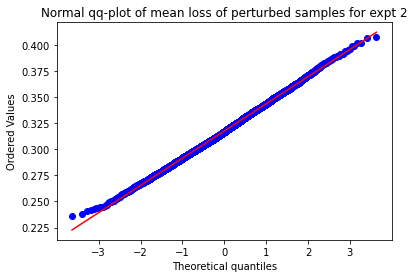

In [1]:
from create_plots import *